In [1]:
import numpy as np
import scipy.io as sio
import mne
import os
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score
from mne import Epochs, pick_types, events_from_annotations
from mne.channels import read_layout
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP


mat = sio.loadmat("data_set_IVa_al.mat", squeeze_me=True) 

In [2]:
tmin, tmax = 0.5, 2.5  
event_id = {'right':1, 'foot':2}

In [3]:
data = mat['cnt'].T / 10000000 
freq = mat['nfo']['fs'][True][0]  

In [4]:
ch_names = mat['nfo']['clab'][True][0]
electrode_x = mat['nfo']['xpos'][True][0]
electrode_y = mat['nfo']['ypos'][True][0]

In [5]:
cue = mat['mrk']['pos'][True][0]  # time of cue
labels = np.nan_to_num(mat['mrk']['y'][True][0]).astype(int)  # convert NaN to 0
trials = np.where(labels == 0)[0][0]  # Number of the total useful trials
print("Number of trials: ", trials)

Number of trials:  224


In [6]:
events = np.zeros((trials, 3), int)
events[:, 0] = cue[:trials]  # The first column is the sample number of the event.
events[:, 2] = labels[:trials]  # The third column is the new event value.
print("events: ", events)

events:  [[  5171      0      1]
 [  5748      0      1]
 [  7385      0      2]
 [  9083      0      1]
 [  9623      0      1]
 [ 10183      0      1]
 [ 10763      0      2]
 [ 12448      0      2]
 [ 13006      0      1]
 [ 13547      0      2]
 [ 14649      0      2]
 [ 15221      0      1]
 [ 15774      0      2]
 [ 16873      0      2]
 [ 17450      0      1]
 [ 18561      0      2]
 [ 21816      0      1]
 [ 22364      0      2]
 [ 25122      0      2]
 [ 25662      0      1]
 [ 27320      0      1]
 [ 27855      0      1]
 [ 28425      0      1]
 [ 28987      0      2]
 [ 29534      0      2]
 [ 30087      0      1]
 [ 30621      0      2]
 [ 31201      0      2]
 [ 31779      0      1]
 [ 32327      0      2]
 [ 32889      0      2]
 [ 33995      0      2]
 [ 34544      0      1]
 [ 37220      0      1]
 [ 37796      0      1]
 [ 38358      0      2]
 [ 38941      0      1]
 [ 40055      0      2]
 [ 40632      0      1]
 [ 42884      0      1]
 [ 43993      0      1]
 [ 4455

In [7]:
ch_names = ch_names.tolist()
info = mne.create_info(ch_names, freq, 'eeg')  # Create info for raw
raw = mne.io.RawArray(data, info, first_samp=0, copy='auto', verbose=None)

Creating RawArray with float64 data, n_channels=118, n_times=283574
    Range : 0 ... 283573 =      0.000 ...  2835.730 secs
Ready.


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 165 samples (1.650 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Using matplotlib as 2D backend.


[Parallel(n_jobs=1)]: Done 118 out of 118 | elapsed:    1.0s finished


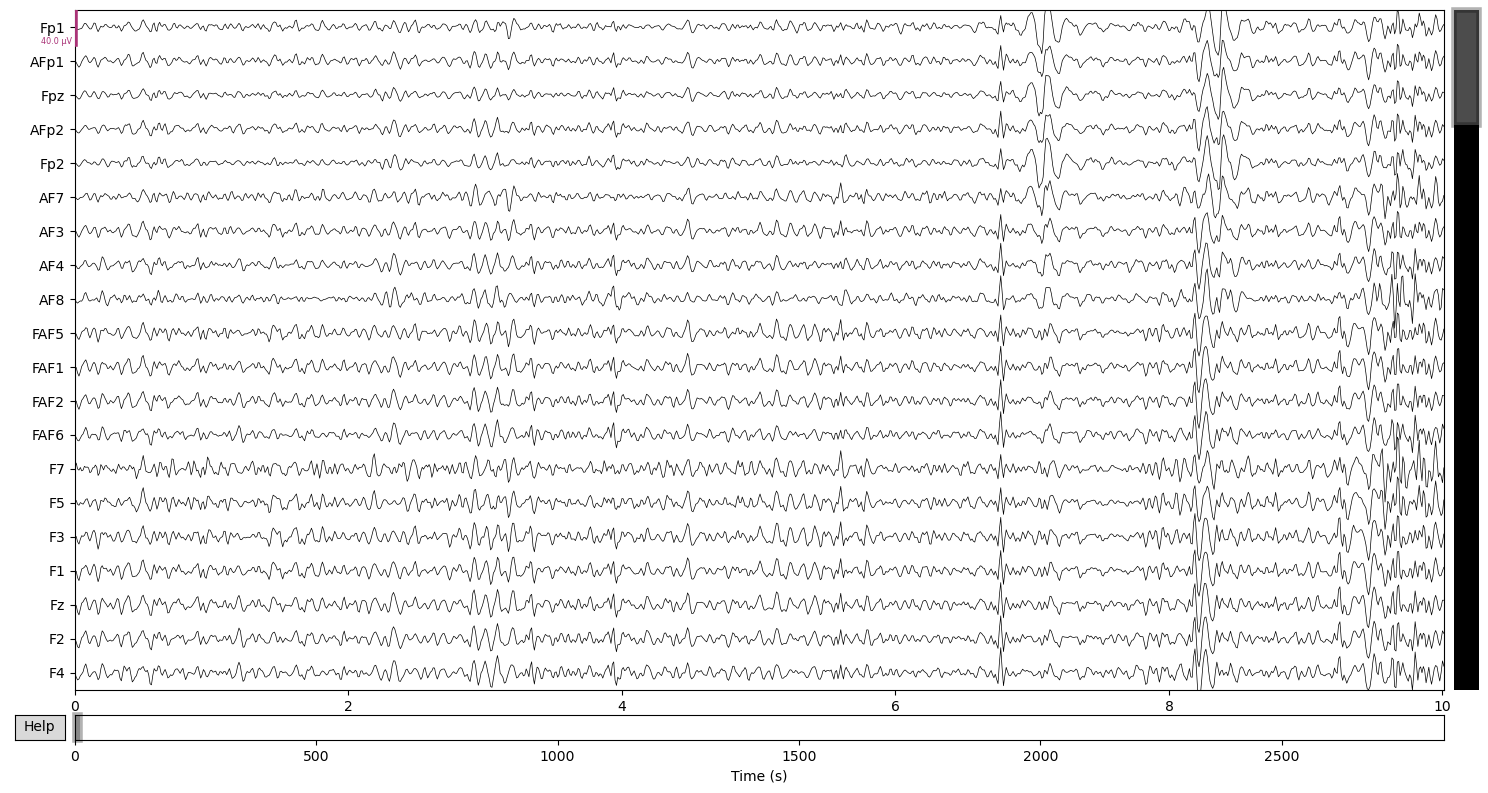

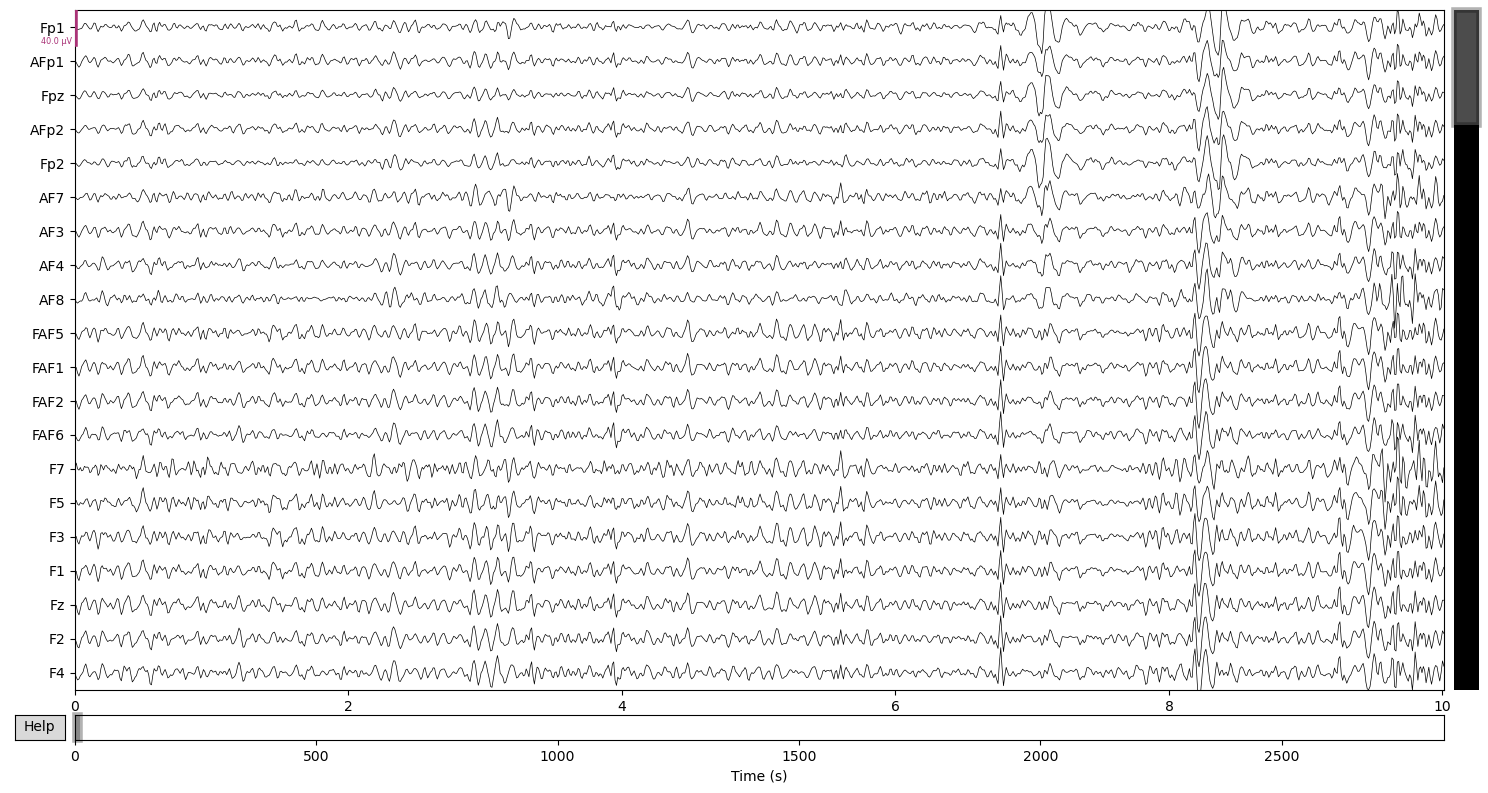

In [8]:
raw.filter(7., 30., fir_design='firwin', skip_by_annotation='edge')
raw.plot()

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 20.480 (s)


C:\Users\HuXiao\AppData\Local\Temp\ipykernel_2832\2847632005.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd()
d:\SoftWare\Conda\envs\pytorch\lib\site-packages\mne\viz\utils.py:161: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


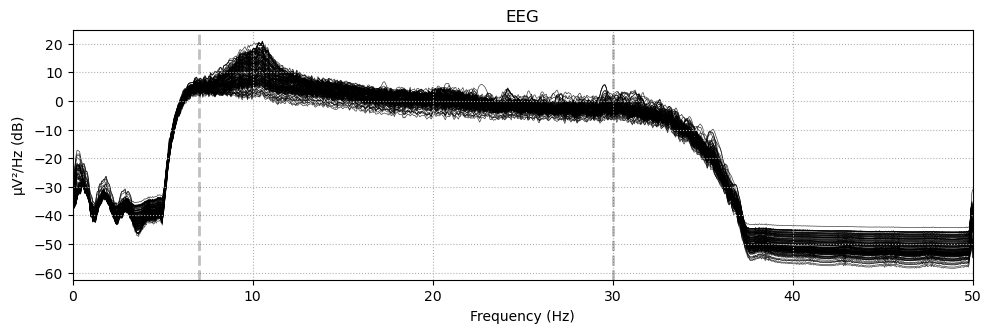

In [9]:
raw.plot_psd()

electrode_matrix:  (3, 118)


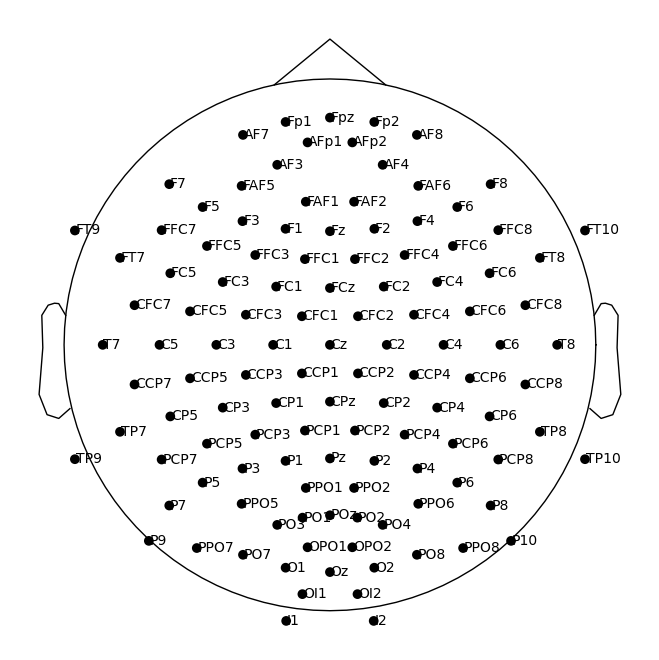

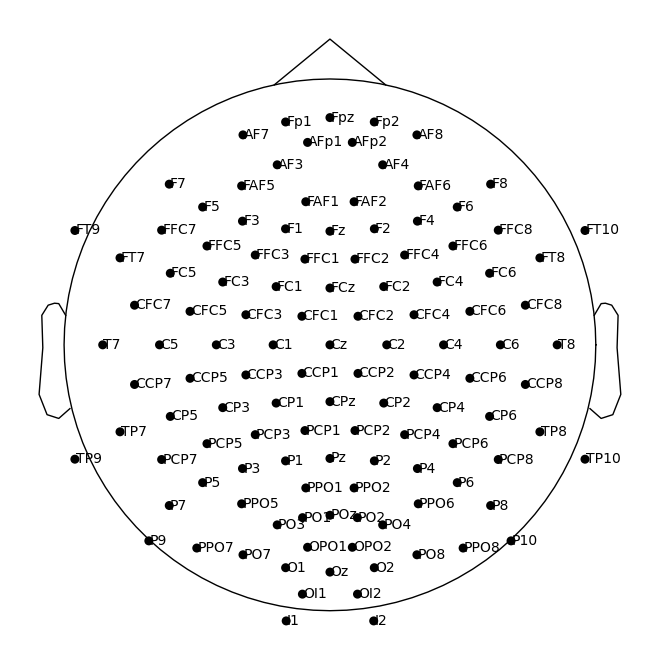

In [18]:
layout_pos = np.vstack((electrode_x, electrode_y))
electrode_z = np.zeros((1, electrode_x.shape[0]))
electrode_matrix = np.vstack((layout_pos, electrode_z))
print("electrode_matrix: ", electrode_matrix.shape)

electrode_dict = {}
for i, ch_name in enumerate(ch_names):
    x = electrode_matrix[0][i]
    y = electrode_matrix[1][i]
    z = electrode_matrix[2][i]
    electrode_vector = [x, y, z]

    electrode_dict[ch_name] = electrode_vector

dig = mne.channels.make_dig_montage(ch_pos=electrode_dict, coord_frame='head')
dig.plot(sphere=0.9)


In [11]:
raw.set_montage(dig)

<RawArray | 118 x 283574 (2835.7 s), ~255.4 MB, data loaded>

In [12]:
picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False, exclude='bads')

epochs = mne.Epochs(raw, events=events, event_id=event_id, tmin=tmin, tmax=tmax, baseline=None, preload=True,
                        verbose=False)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


[Parallel(n_jobs=1)]: Done 118 out of 118 | elapsed:    4.0s finished


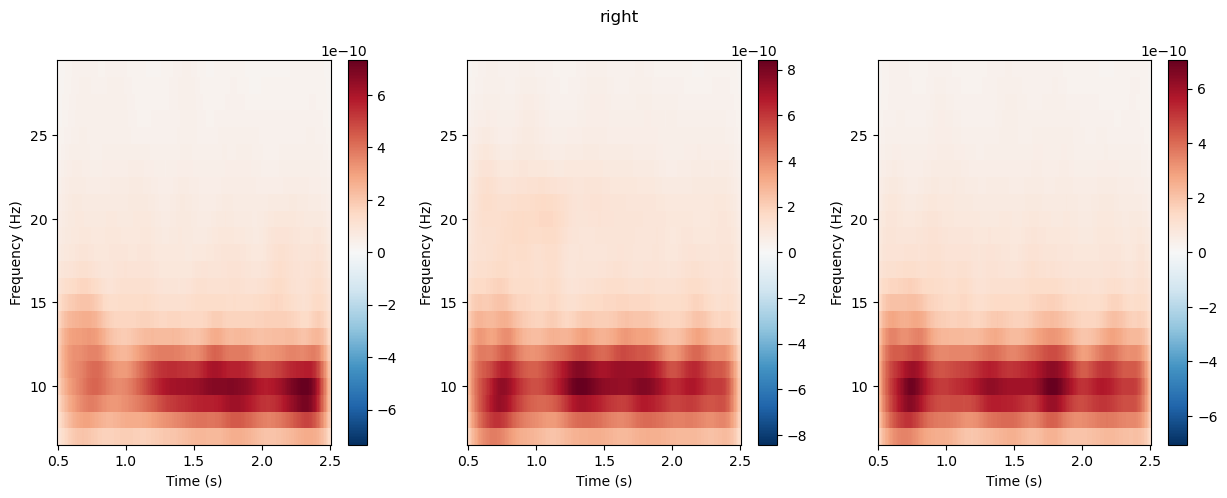

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


[Parallel(n_jobs=1)]: Done 118 out of 118 | elapsed:    4.3s finished


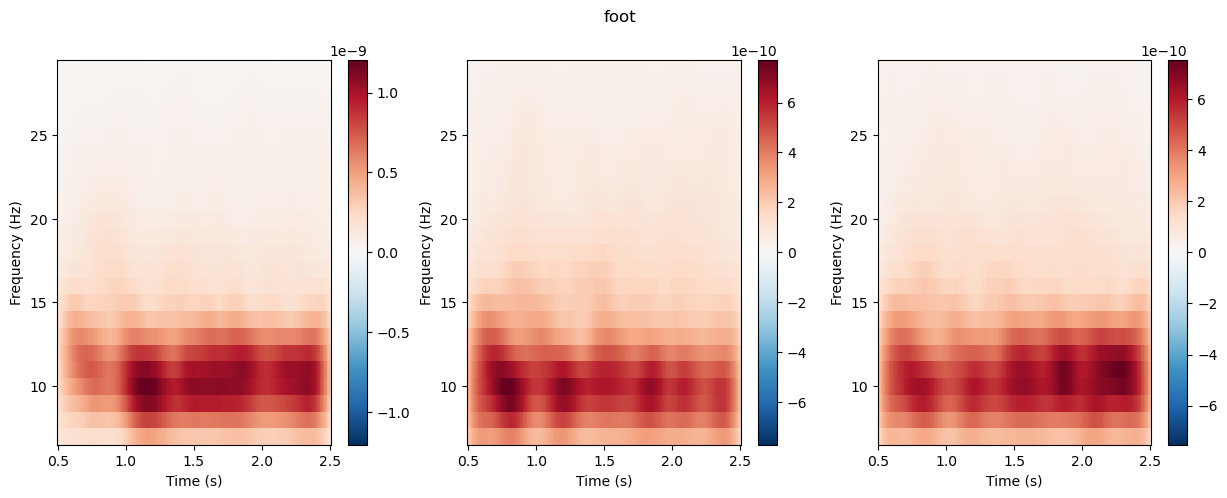

In [13]:
freqs = np.arange(7, 30, 1)
channels = ['C3', 'Cz', 'C4']
events = ['right', 'foot']

for e in events:
    power = mne.time_frequency.tfr_morlet(epochs[e], freqs=freqs, n_cycles=freqs/2, return_itc=False)
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    for i in range(3):
        power.plot([channels[i]], axes=axes[i], show=False)
    plt.suptitle(e)
    plt.show()



In [14]:
epochs_train = epochs.copy().crop(tmin=1., tmax=2.)
labels = epochs.events[:, -1] - 1

In [15]:
# 评价指标
scores = []
# 获取epochs的所有数据，主要用于后面的滑动窗口验证
epochs_data = epochs.get_data()
# 获取训练数据
epochs_data_train = epochs_train.get_data()
# 设置交叉验证模型的参数
cv = ShuffleSplit(10, test_size=0.2, random_state=42)
# 根据设计的交叉验证参数,分配相关的训练集和测试集数据
cv_split = cv.split(epochs_data_train)
# 创建线性分类器
lda = LinearDiscriminantAnalysis()
# 创建CSP提取特征，这里使用4个分量的CSP
csp = CSP(n_components=4, reg=None, log=False, norm_trace=False)
# 创建机器学习的Pipeline,也就是分类模型，使用这种方式可以把特征提取和分类统一整合到了clf中
clf = Pipeline([('CSP', csp), ('LDA', lda)])
# 获取交叉验证模型的得分
scores = cross_val_score(clf, epochs_data_train, labels, cv=cv, n_jobs=1)
# 输出结果，准确率和不同样本的占比
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1. - class_balance)
print("Classification accuracy: %f / Chance level: %f" % (np.mean(scores), class_balance))
# csp提取特征,用于绘制CSP不同分量的模式图（地形图）
# 如果没有这一步csp.plot_patterns将不会执行
csp.fit_transform(epochs_data, labels)

Computing rank from data with rank=None


    Using tolerance 0.00018 (2.2e-16 eps * 118 dim * 6.9e+09  max singular value)
    Estimated rank (mag): 118
    MAG: rank 118 computed from 118 data channels with 0 projectors
Reducing data rank from 118 -> 118
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00018 (2.2e-16 eps * 118 dim * 6.9e+09  max singular value)
    Estimated rank (mag): 118
    MAG: rank 118 computed from 118 data channels with 0 projectors
Reducing data rank from 118 -> 118
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00018 (2.2e-16 eps * 118 dim * 7.1e+09  max singular value)
    Estimated rank (mag): 118
    MAG: rank 118 computed from 118 data channels with 0 projectors
Reducing data rank from 118 -> 118
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00018 (2.2e-16 eps * 118 dim * 6.9e+09  max singular value)
    Estimated rank (m

array([[-8.51366657e-01, -8.75789359e-01, -8.98762582e-01,
        -7.62950417e-01],
       [-8.34220745e-01, -8.87920775e-01, -7.37752467e-01,
        -9.46663854e-01],
       [-5.57387086e-02, -2.10189432e-01,  1.24696700e-01,
         5.01606949e-02],
       [-8.38555720e-01, -5.78488903e-01, -7.90903032e-01,
         3.12436042e-01],
       [-8.03946401e-01, -7.91520546e-01, -7.55824150e-01,
        -7.65365390e-01],
       [-8.01989281e-01, -7.47428222e-01, -7.93400097e-01,
        -6.05377712e-01],
       [ 9.18693031e-01,  1.64028685e+00,  1.26486512e+00,
         2.47566515e+00],
       [ 9.90104504e-01,  1.61856934e+00,  6.82332355e-01,
         7.58263847e-01],
       [-8.46949574e-01, -7.76576216e-01, -8.00200608e-01,
        -8.11134021e-01],
       [ 8.88792736e-01,  3.87198338e-01, -4.77899164e-02,
         8.80493742e-02],
       [ 1.21383824e+00,  1.80082301e+00,  3.90863897e-01,
         2.73891328e+00],
       [-8.01263854e-01, -7.64289250e-01, -7.79413009e-01,
      

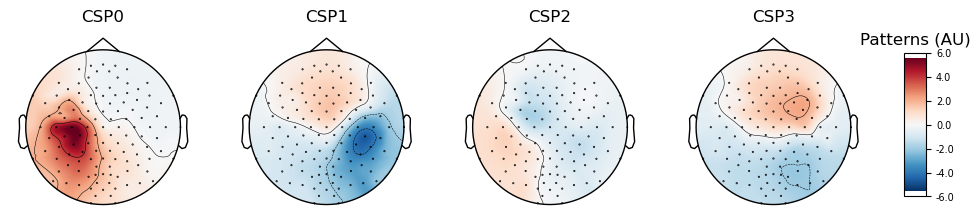

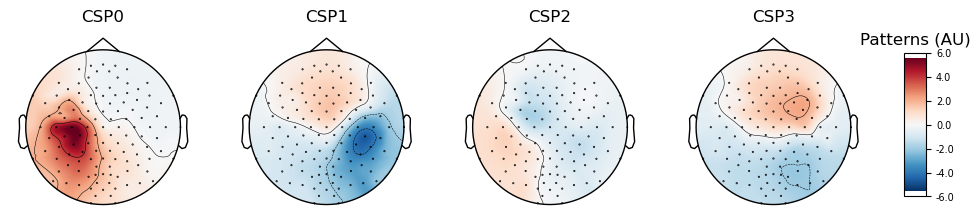

In [16]:
csp.plot_patterns(epochs.info, ch_type='eeg', units='Patterns (AU)', size=1.5, show=True, sphere=0.95)

Computing rank from data with rank=None


    Using tolerance 0.00018 (2.2e-16 eps * 118 dim * 6.9e+09  max singular value)
    Estimated rank (mag): 118
    MAG: rank 118 computed from 118 data channels with 0 projectors
Reducing data rank from 118 -> 118
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00018 (2.2e-16 eps * 118 dim * 6.9e+09  max singular value)
    Estimated rank (mag): 118
    MAG: rank 118 computed from 118 data channels with 0 projectors
Reducing data rank from 118 -> 118
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00018 (2.2e-16 eps * 118 dim * 7.1e+09  max singular value)
    Estimated rank (mag): 118
    MAG: rank 118 computed from 118 data channels with 0 projectors
Reducing data rank from 118 -> 118
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00018 (2.2e-16 eps * 118 dim * 6.9e+09  max singular value)
    Estimated rank (m

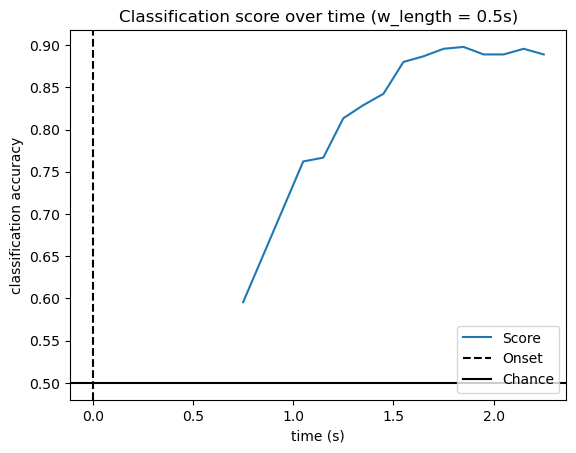

In [17]:
# 获取数据的采样频率
sfreq = raw.info['sfreq']
# 设置滑动窗口的长度，也就是数据窗口的长度
w_length = int(sfreq * 0.5)
# 设置滑动步长，每次滑动的数据间隔
w_step = int(sfreq * 0.1)
# 每次滑动窗口的起始点
w_start = np.arange(0, epochs_data.shape[2] - w_length, w_step)
# 得分列表用于保存模型得分
scores_windows = []
# 交叉验证计算模型的性能
for train_idx, test_idx in cv_split:
    # 获取测试集和训练集数据
    y_train, y_test = labels[train_idx], labels[test_idx]
    # 设置csp模型的参数，提取相关特征，用于后面的lda分类
    X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
    # 拟合lda模型
    lda.fit(X_train, y_train)
    # 用于记录本次交叉验证的得分
    score_this_window = []
    for n in w_start:
        # csp提取测试数据相关特征
        X_test = csp.transform(epochs_data[test_idx][:, :, n:(n + w_length)])
        # 获取测试数据得分
        score_this_window.append(lda.score(X_test, y_test))
    # 添加到总得分列表
    scores_windows.append(score_this_window)
 
# 设置绘图的时间轴，时间轴上的标志点为窗口的中间位置
w_times = (w_start + w_length / 2.) / sfreq + epochs.tmin
# 绘制模型分类结果的性能图（得分的均值）
plt.figure()
plt.plot(w_times, np.mean(scores_windows, 0), label='Score')
plt.axvline(0, linestyle='--', color='k', label='Onset')
plt.axhline(0.5, linestyle='-', color='k', label='Chance')
plt.xlabel('time (s)')
plt.ylabel('classification accuracy')
plt.title('Classification score over time (w_length = {0}s)'.format(w_length/sfreq))
plt.legend(loc='lower right')
plt.show()